Прогнозирование Trans-MAF датасета Exchange, обрезая его с 2009 года.

## Imports

In [ ]:

import sys

sys.path.append('../pytorch-ts')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import MultivariateEvaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from pts import Trainer
from pts.model.transformer_tempflow import TransformerTempFlowEstimator

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Read Datasets

In [ ]:
exchange = get_dataset("exchange_rate", regenerate=False)

In [ ]:
# exchange
exchange_train_grouper = MultivariateGrouper(
    max_target_dim=min(2000, int(exchange.metadata.feat_static_cat[0].cardinality))
    )

exchange_test_grouper = MultivariateGrouper(
    num_test_dates=int(len(exchange.test) / len(exchange.train)), 
    max_target_dim=min(2000, int(exchange.metadata.feat_static_cat[0].cardinality))
    )

In [ ]:
# exchange
exchange_dataset_train = exchange_train_grouper(exchange.train)
exchange_dataset_test = exchange_test_grouper(exchange.test)

### Обрежем exchange по 2009 год

In [68]:
# start date of exchange
exchange_start = exchange_dataset_train[0]['start'].to_timestamp()

# number of points from beginning of exchange till 2009 
cut_length = pd.date_range(exchange_start, '2009-01-01', freq='B').__len__()

# cut exchange train
exchange_dataset_train[0]['target'] = exchange_dataset_train[0]['target'][:, cut_length:]
exchange_dataset_train[0]['start'] = pd.Period('2009-01-01', 'B')

# cut exchange test
for dataset in exchange_dataset_test:
    dataset['target'] = dataset['target'][:, cut_length:]
    dataset['start'] = pd.Period('2009-01-01', 'B')

In [75]:
exchange_dataset_train = list(exchange_train_grouper(exchange.train))
exchange_dataset_train *= 100 

In [84]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

## Train model

### Echange

In [77]:
exchange.metadata.freq

'1B'

In [78]:
exchange_freq = 'B'

In [86]:
# init estimator
estimator = TransformerTempFlowEstimator(
    input_size=28,
    target_dim=int(exchange.metadata.feat_static_cat[0].cardinality),
    prediction_length=exchange.metadata.prediction_length,
    context_length=exchange.metadata.prediction_length * 4, # increase prediction context length
    flow_type='MAF',
    dequantize=True,
    freq=exchange_freq,
    scaling=True,
    trainer=Trainer(
        device='cpu',
        epochs=14, 
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    )
)

# train
predictor = estimator.train(
    exchange_dataset_train, 
    num_workers=4
    )

  0%|          | 0/99 [00:00<?, ?it/s]

/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/multiprocessing/spawn.py:126: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  self = reduction.pickle.load(from_parent)
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/multiprocessing/spawn.py:126: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  self = reduction.pickle.lo

In [87]:
# init evaluator
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20)/20.0)[1:],
    target_agg_funcs={'sum': np.sum}
)

# prediction
forecast_it, ts_it = make_evaluation_predictions(
    dataset=exchange_dataset_test,
    predictor=predictor,
    num_samples=20
)

forecasts = list(forecast_it)
targets = list(ts_it)

# calculate metrics
agg_metric, _ = evaluator(
    targets, 
    forecasts, 
    num_series=len(exchange_dataset_test)
    )

Running evaluation: 5it [00:00, 232.24it/s]
Running evaluation: 5it [00:00, 250.49it/s]
Running evaluation: 5it [00:00, 264.59it/s]
Running evaluation: 5it [00:00, 245.84it/s]
Running evaluation: 5it [00:00, 231.50it/s]
Running evaluation: 5it [00:00, 227.99it/s]
Running evaluation: 5it [00:00, 214.59it/s]
Running evaluation: 5it [00:00, 247.38it/s]
Running evaluation: 5it [00:00, 220.47it/s]


#### Metrics

In [88]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS: 0.5769390830778459
ND: 0.8004220372386814
NRMSE: 0.7958924964845001
MSE: 0.41901077429453537
CRPS-Sum: 0.7052313588095293
ND-Sum: 0.7842401268035702
NRMSE-Sum: 0.785842600189339
MSE-Sum: 26.1437255859375


Notes:
- обрезка трейн выборки до 2009 года не улучшает метрику (scaling=False)
- обрезка трейн выборки до 2009 года не улучшает метрику + scaling=True - значительно ухудшает метрику

#### Actual/forecast visualisation

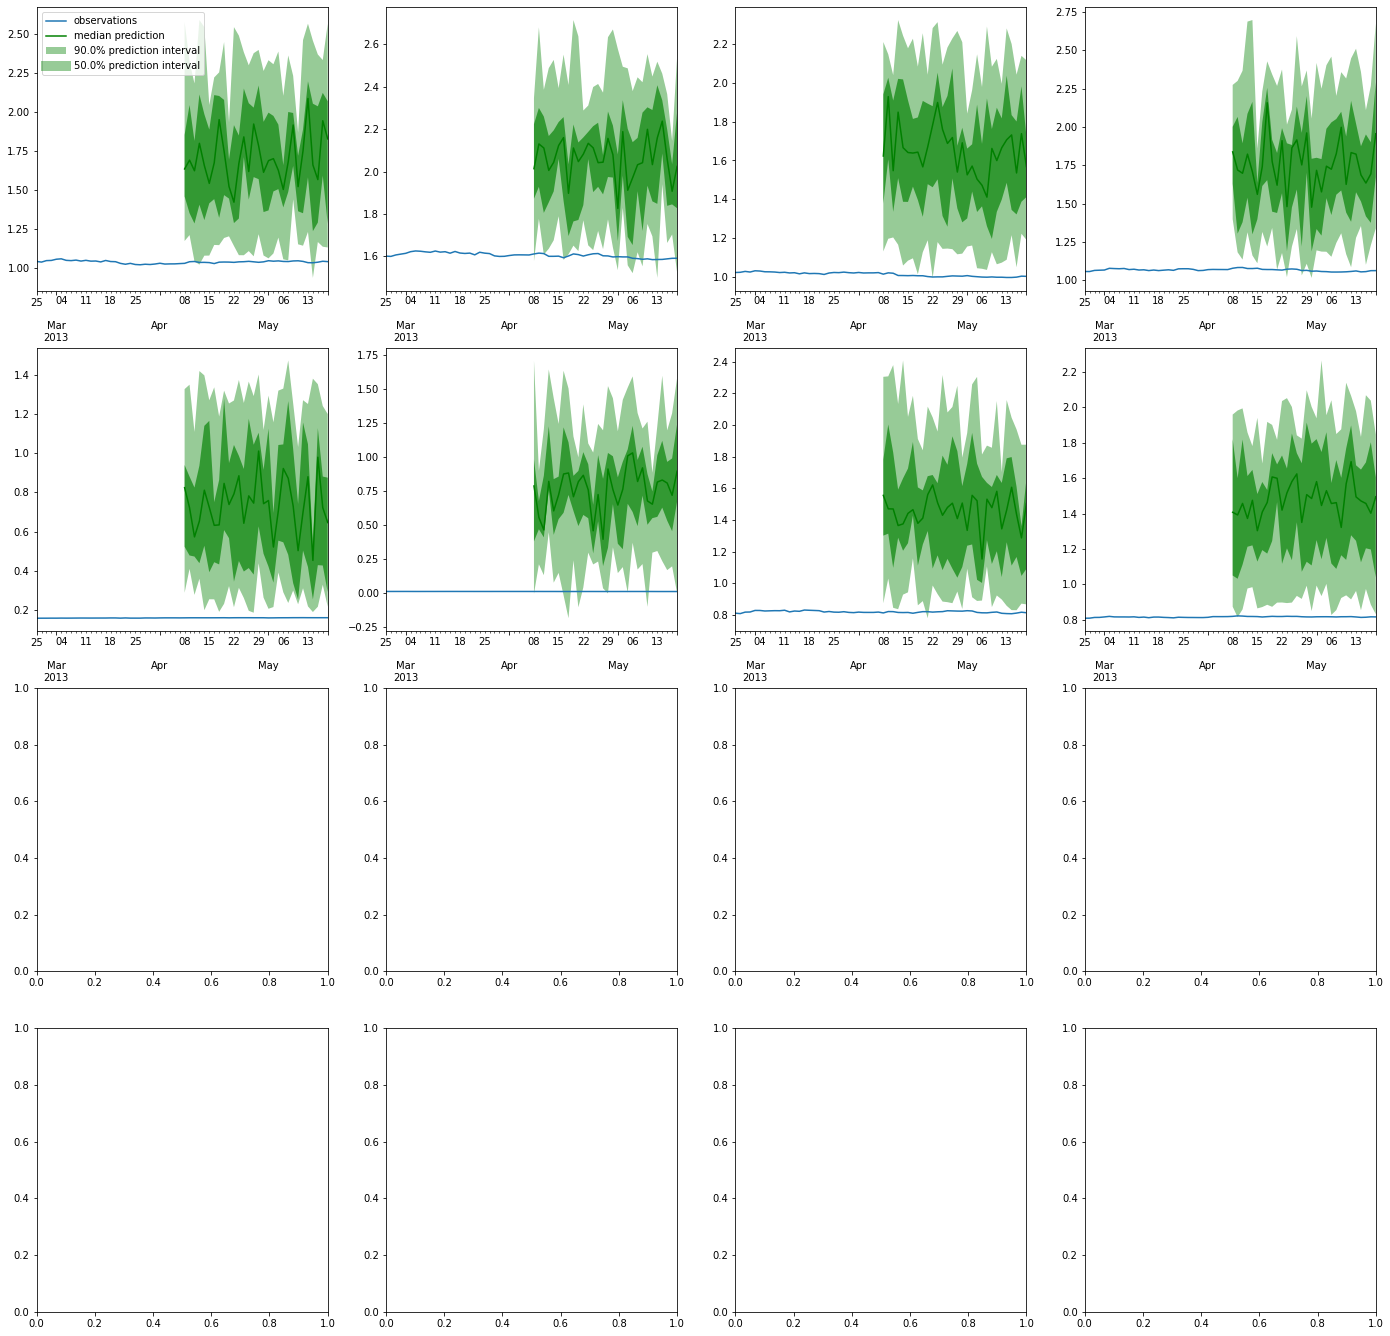

In [89]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=exchange.metadata.prediction_length,
)

plt.show()